## Completed

In [1]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# LOADING THE DATASET
import gdown

# Google Sheets URL (Updated)
google_sheets_url = "https://docs.google.com/spreadsheets/d/1-W2T0UeZuK7Wk1_3tlV14iFMlIAadczV/export?format=xlsx"

# Download file
output_file = 'Residuals_SVR_Predictions_SARIMA.xlsx'
gdown.download(google_sheets_url, output=output_file, quiet=False)

# Load data
data = pd.read_excel(output_file)

# Initial display
print(data.head())

# Copy and explore
df = data.copy()
print(df.columns)

# Display column names
df.columns


Downloading...
From: https://docs.google.com/spreadsheets/d/1-W2T0UeZuK7Wk1_3tlV14iFMlIAadczV/export?format=xlsx
To: /content/Residuals_SVR_Predictions_SARIMA.xlsx
25.9kB [00:00, 3.87MB/s]


        Date  Inflation  SVR_Prediction  Residuals_SVR
0 2000-10-31   7.794494        7.786219       0.008275
1 2000-11-30   7.559566        7.864713      -0.305147
2 2000-12-31  10.836729        7.248605       3.588124
3 2001-01-31  16.170425       11.308153       4.862272
4 2001-02-28  16.618124       18.530548      -1.912424
Index(['Date', 'Inflation', 'SVR_Prediction', 'Residuals_SVR'], dtype='object')


Index(['Date', 'Inflation', 'SVR_Prediction', 'Residuals_SVR'], dtype='object')

In [2]:

! pip install optuna
# Set 'Date' as the index
df.set_index('Date', inplace=True)
df


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 8.6 MB/s eta 0:00:00


,Inflation,SVR_Prediction,Residuals_SVR
Date,,,
2000-10-31,7.794494,7.786219,0.008275
2000-11-30,7.559566,7.864713,-0.305147
2000-12-31,10.836729,7.248605,3.588124
2001-01-31,16.170425,11.308153,4.862272
2001-02-28,16.618124,18.530548,-1.912424
...,...,...,...
2024-11-30,-2.068252,-1.504964,-0.563288
2024-12-31,-1.742696,-2.050241,0.307545
2025-01-31,-4.035874,-1.555624,-2.480250


In [3]:
df_backup=df.copy()
df_backup

,Inflation,SVR_Prediction,Residuals_SVR
Date,,,
2000-10-31,7.794494,7.786219,0.008275
2000-11-30,7.559566,7.864713,-0.305147
2000-12-31,10.836729,7.248605,3.588124
2001-01-31,16.170425,11.308153,4.862272
2001-02-28,16.618124,18.530548,-1.912424
...,...,...,...
2024-11-30,-2.068252,-1.504964,-0.563288
2024-12-31,-1.742696,-2.050241,0.307545
2025-01-31,-4.035874,-1.555624,-2.480250


In [4]:
df=df[["Residuals_SVR"]]
df

,Residuals_SVR
Date,
2000-10-31,0.008275
2000-11-30,-0.305147
2000-12-31,3.588124
2001-01-31,4.862272
2001-02-28,-1.912424
...,...
2024-11-30,-0.563288
2024-12-31,0.307545
2025-01-31,-2.480250


In [5]:
data=df.copy()
data

,Residuals_SVR
Date,
2000-10-31,0.008275
2000-11-30,-0.305147
2000-12-31,3.588124
2001-01-31,4.862272
2001-02-28,-1.912424
...,...
2024-11-30,-0.563288
2024-12-31,0.307545
2025-01-31,-2.480250


In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import optuna


import numpy as np
import pandas as pd
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# --- Load your dataset ---
# Make sure you already have 'df' loaded and 'Residuals_SVR' column exists

# Train-test split
train_size = int(len(df) * 0.9)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Use the target variable as Residuals_SVR data (y)
y_train = train_data['Residuals_SVR']  # Replace with your actual column name if different
y_test = test_data['Residuals_SVR']

# Normalize the target using StandardScaler
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Prepare data for LSTM (create sequences)
def create_sequences(y_scaled, n_past, n_future):
    X, y_data = [], []
    for i in range(n_past, len(y_scaled) - n_future + 1):
        X.append(y_scaled[i - n_past:i, 0])
        y_data.append(y_scaled[i + n_future - 1:i + n_future, 0])
    return np.array(X), np.array(y_data)


In [ ]:

# Objective function for Optuna
def objective(trial, y_train_scaled):
    n_past = trial.suggest_int("n_past", 1, 24)  # Time step size
    n_neurons = trial.suggest_int("n_neurons", 16, 128)
    n_layers = trial.suggest_int("n_layers", 1, 4)
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [1, 4, 8, 16, 32])
    optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])
    epochs = trial.suggest_int("epochs", 10, 100)

    # Create sequences
    X, y_seq = create_sequences(y_train_scaled, n_past, 1)

    # Reshape input to (samples, time_steps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    mse_scores = []

    # TimeSeriesSplit cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_seq[train_idx], y_seq[val_idx]

        # Build model
        model = Sequential()


        # First LSTM layer
        model.add(LSTM(n_neurons, return_sequences=(n_layers > 1), activation=activation,
                        input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))


        # Additional LSTM layers
        for i in range(1, n_layers):
            return_seq = (i < n_layers - 1)  # True for intermediate layers, False for last
            model.add(LSTM(n_neurons, return_sequences=return_seq, activation=activation))
            model.add(Dropout(dropout_rate))

        # Output layer
        model.add(Dense(1))

        # Compile model
        model.compile(optimizer=optimizer, loss="mean_squared_error")

        # Train model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict and evaluate
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Create and run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, y_train_scaled), n_trials=50)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)


[I 2025-05-15 08:17:54,061] A new study created in memory with name: no-name-9c476f05-935e-456e-9046-2148b0bc270f


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


[I 2025-05-15 08:20:41,544] Trial 0 finished with value: 1.2479054822799966 and parameters: {'n_past': 10, 'n_neurons': 56, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.18696931933277208, 'batch_size': 1, 'optimizer': 'adam', 'epochs': 43}. Best is trial 0 with value: 1.2479054822799966.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 495ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 482ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 497ms/step


[I 2025-05-15 08:21:08,175] Trial 1 finished with value: 0.8901240739999363 and parameters: {'n_past': 2, 'n_neurons': 67, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.2855281143512583, 'batch_size': 16, 'optimizer': 'sgd', 'epochs': 12}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


[I 2025-05-15 08:48:39,113] Trial 2 finished with value: 0.9588670147697538 and parameters: {'n_past': 21, 'n_neurons': 125, 'n_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.2748319300725267, 'batch_size': 1, 'optimizer': 'sgd', 'epochs': 53}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 705ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


[I 2025-05-15 08:50:43,670] Trial 3 finished with value: 0.9339701953748805 and parameters: {'n_past': 18, 'n_neurons': 118, 'n_layers': 4, 'activation': 'sigmoid', 'dropout_rate': 0.25128039739528185, 'batch_size': 32, 'optimizer': 'rmsprop', 'epochs': 24}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


[I 2025-05-15 08:51:36,113] Trial 4 finished with value: 0.9579068271135129 and parameters: {'n_past': 21, 'n_neurons': 96, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.4602620292869266, 'batch_size': 16, 'optimizer': 'sgd', 'epochs': 53}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 936ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


[I 2025-05-15 08:53:18,886] Trial 5 finished with value: 2.487143912569942 and parameters: {'n_past': 1, 'n_neurons': 28, 'n_layers': 4, 'activation': 'relu', 'dropout_rate': 0.17401533729827817, 'batch_size': 16, 'optimizer': 'adam', 'epochs': 87}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 482ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


[I 2025-05-15 09:16:01,445] Trial 6 finished with value: 0.9913627462226418 and parameters: {'n_past': 23, 'n_neurons': 87, 'n_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.4426670934814857, 'batch_size': 1, 'optimizer': 'sgd', 'epochs': 50}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step


[I 2025-05-15 09:18:10,480] Trial 7 finished with value: 0.9386592214641709 and parameters: {'n_past': 7, 'n_neurons': 68, 'n_layers': 2, 'activation': 'sigmoid', 'dropout_rate': 0.2932400483662416, 'batch_size': 4, 'optimizer': 'rmsprop', 'epochs': 55}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step


[I 2025-05-15 09:19:55,268] Trial 8 finished with value: 0.9322205580166987 and parameters: {'n_past': 14, 'n_neurons': 66, 'n_layers': 2, 'activation': 'relu', 'dropout_rate': 0.2915505850125004, 'batch_size': 16, 'optimizer': 'sgd', 'epochs': 86}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step


[I 2025-05-15 09:21:31,262] Trial 9 finished with value: 1.1492405245579882 and parameters: {'n_past': 7, 'n_neurons': 90, 'n_layers': 2, 'activation': 'tanh', 'dropout_rate': 0.29430891926743624, 'batch_size': 4, 'optimizer': 'adam', 'epochs': 34}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step


[I 2025-05-15 09:22:00,990] Trial 10 finished with value: 0.8936409895882061 and parameters: {'n_past': 1, 'n_neurons': 37, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.39827238421066724, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 11}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


[I 2025-05-15 09:22:28,389] Trial 11 finished with value: 0.8927690223480788 and parameters: {'n_past': 1, 'n_neurons': 34, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.3894513695603451, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 10}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 485ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


[I 2025-05-15 09:22:57,986] Trial 12 finished with value: 0.8970887482095902 and parameters: {'n_past': 5, 'n_neurons': 40, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.3809550060887631, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 10}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 737ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


[I 2025-05-15 09:23:58,952] Trial 13 finished with value: 0.8992640099388041 and parameters: {'n_past': 4, 'n_neurons': 18, 'n_layers': 4, 'activation': 'relu', 'dropout_rate': 0.37215377348446504, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 26}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step


[I 2025-05-15 09:25:11,414] Trial 14 finished with value: 0.9170067268859121 and parameters: {'n_past': 12, 'n_neurons': 52, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.10821609856078493, 'batch_size': 32, 'optimizer': 'sgd', 'epochs': 67}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step


[I 2025-05-15 09:25:52,243] Trial 15 finished with value: 0.9869605700491235 and parameters: {'n_past': 4, 'n_neurons': 50, 'n_layers': 2, 'activation': 'relu', 'dropout_rate': 0.33927165851715435, 'batch_size': 8, 'optimizer': 'rmsprop', 'epochs': 22}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 999ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 904ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


[I 2025-05-15 09:28:18,485] Trial 16 finished with value: 0.9070163498392085 and parameters: {'n_past': 9, 'n_neurons': 78, 'n_layers': 4, 'activation': 'tanh', 'dropout_rate': 0.22823863763455005, 'batch_size': 16, 'optimizer': 'sgd', 'epochs': 70}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


[I 2025-05-15 09:29:50,205] Trial 17 finished with value: 0.895499589285048 and parameters: {'n_past': 1, 'n_neurons': 16, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.49173885587220295, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 100}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step


[I 2025-05-15 09:31:05,017] Trial 18 finished with value: 0.9258946638630867 and parameters: {'n_past': 16, 'n_neurons': 112, 'n_layers': 2, 'activation': 'relu', 'dropout_rate': 0.35697108015249623, 'batch_size': 16, 'optimizer': 'adam', 'epochs': 37}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 779ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 942ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


[I 2025-05-15 09:32:53,647] Trial 19 finished with value: 0.8960795597022255 and parameters: {'n_past': 4, 'n_neurons': 103, 'n_layers': 4, 'activation': 'tanh', 'dropout_rate': 0.33849006360096845, 'batch_size': 4, 'optimizer': 'rmsprop', 'epochs': 18}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


[I 2025-05-15 09:33:39,312] Trial 20 finished with value: 0.9075590970120233 and parameters: {'n_past': 7, 'n_neurons': 77, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.4168378424136334, 'batch_size': 32, 'optimizer': 'sgd', 'epochs': 35}. Best is trial 1 with value: 0.8901240739999363.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


[I 2025-05-15 09:34:06,906] Trial 21 finished with value: 0.8847477787286145 and parameters: {'n_past': 1, 'n_neurons': 36, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.4097144947295017, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 10}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


[I 2025-05-15 09:34:44,456] Trial 22 finished with value: 0.9041306473043769 and parameters: {'n_past': 3, 'n_neurons': 30, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.43193493058395777, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 13}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


[I 2025-05-15 09:35:20,540] Trial 23 finished with value: 0.8923739935576794 and parameters: {'n_past': 1, 'n_neurons': 42, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.32609352819648785, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 18}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step


[I 2025-05-15 09:36:06,796] Trial 24 finished with value: 0.9018179573510284 and parameters: {'n_past': 6, 'n_neurons': 46, 'n_layers': 2, 'activation': 'relu', 'dropout_rate': 0.3288203092822817, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 30}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 484ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


[I 2025-05-15 09:36:39,544] Trial 25 finished with value: 0.8948978107238347 and parameters: {'n_past': 3, 'n_neurons': 64, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.23140611066508676, 'batch_size': 16, 'optimizer': 'sgd', 'epochs': 21}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 935ms/step


[I 2025-05-15 09:37:43,189] Trial 26 finished with value: 0.9112814765257207 and parameters: {'n_past': 9, 'n_neurons': 59, 'n_layers': 4, 'activation': 'relu', 'dropout_rate': 0.3202418104967484, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 18}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 495ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 485ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


[I 2025-05-15 09:38:48,840] Trial 27 finished with value: 0.8956128220258381 and parameters: {'n_past': 3, 'n_neurons': 43, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.48934500367650996, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 43}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step


[I 2025-05-15 09:39:24,323] Trial 28 finished with value: 1.003974729897952 and parameters: {'n_past': 2, 'n_neurons': 24, 'n_layers': 2, 'activation': 'tanh', 'dropout_rate': 0.18815003200496383, 'batch_size': 16, 'optimizer': 'adam', 'epochs': 17}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


[I 2025-05-15 09:42:20,852] Trial 29 finished with value: 0.9882400014489434 and parameters: {'n_past': 11, 'n_neurons': 57, 'n_layers': 1, 'activation': 'sigmoid', 'dropout_rate': 0.2696500884108781, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 43}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 767ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


[I 2025-05-15 09:45:01,636] Trial 30 finished with value: 0.9153188775430958 and parameters: {'n_past': 9, 'n_neurons': 76, 'n_layers': 4, 'activation': 'tanh', 'dropout_rate': 0.19933916387131614, 'batch_size': 4, 'optimizer': 'adam', 'epochs': 27}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


[I 2025-05-15 09:45:31,298] Trial 31 finished with value: 0.8901194885211222 and parameters: {'n_past': 1, 'n_neurons': 32, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.39752306637530066, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 14}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


[I 2025-05-15 09:46:16,093] Trial 32 finished with value: 0.8990199284267227 and parameters: {'n_past': 5, 'n_neurons': 25, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.41150904173327024, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 16}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


[I 2025-05-15 09:47:02,352] Trial 33 finished with value: 0.8948119228378623 and parameters: {'n_past': 2, 'n_neurons': 35, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.3642329614200924, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 30}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 492ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step


[I 2025-05-15 09:48:37,993] Trial 34 finished with value: 0.8871202526055999 and parameters: {'n_past': 2, 'n_neurons': 49, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.45033280475869414, 'batch_size': 1, 'optimizer': 'sgd', 'epochs': 21}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 484ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 474ms/step


[I 2025-05-15 09:50:42,054] Trial 35 finished with value: 0.8936159817128713 and parameters: {'n_past': 5, 'n_neurons': 51, 'n_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.4543609928857984, 'batch_size': 1, 'optimizer': 'sgd', 'epochs': 24}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 903ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


[I 2025-05-15 09:54:40,758] Trial 36 finished with value: 0.9550072567795423 and parameters: {'n_past': 19, 'n_neurons': 60, 'n_layers': 4, 'activation': 'relu', 'dropout_rate': 0.45976179019652974, 'batch_size': 1, 'optimizer': 'sgd', 'epochs': 14}. Best is trial 21 with value: 0.8847477787286145.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 497ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


[I 2025-05-15 09:59:15,509] Trial 37 finished with value: 0.8800498393859602 and parameters: {'n_past': 3, 'n_neurons': 47, 'n_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.43395311782482304, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 63}. Best is trial 37 with value: 0.8800498393859602.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


[I 2025-05-15 10:04:52,108] Trial 38 finished with value: 0.8839307512714868 and parameters: {'n_past': 3, 'n_neurons': 47, 'n_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.47885158402309735, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 64}. Best is trial 37 with value: 0.8800498393859602.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step


[I 2025-05-15 10:09:56,921] Trial 39 finished with value: 0.903232948639223 and parameters: {'n_past': 6, 'n_neurons': 46, 'n_layers': 2, 'activation': 'sigmoid', 'dropout_rate': 0.4837829286334139, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 65}. Best is trial 37 with value: 0.8800498393859602.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step


[I 2025-05-15 10:13:09,236] Trial 40 finished with value: 1.0258714844754238 and parameters: {'n_past': 3, 'n_neurons': 54, 'n_layers': 1, 'activation': 'sigmoid', 'dropout_rate': 0.4320961090353683, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 75}. Best is trial 37 with value: 0.8800498393859602.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 494ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step


[I 2025-05-15 10:17:16,962] Trial 41 finished with value: 0.8952152193252779 and parameters: {'n_past': 2, 'n_neurons': 32, 'n_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.47023543031092774, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 60}. Best is trial 37 with value: 0.8800498393859602.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 474ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


[I 2025-05-15 10:22:36,355] Trial 42 finished with value: 0.8929739127612549 and parameters: {'n_past': 2, 'n_neurons': 25, 'n_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.41319496416994284, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 78}. Best is trial 37 with value: 0.8800498393859602.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 496ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 496ms/step


[I 2025-05-15 10:27:39,505] Trial 43 finished with value: 0.8939212646890944 and parameters: {'n_past': 4, 'n_neurons': 38, 'n_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.442465982119164, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 61}. Best is trial 37 with value: 0.8800498393859602.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 495ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


[I 2025-05-15 10:31:18,769] Trial 44 finished with value: 0.8950356531675835 and parameters: {'n_past': 1, 'n_neurons': 47, 'n_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.4725034242190463, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 48}. Best is trial 37 with value: 0.8800498393859602.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


[I 2025-05-15 10:39:49,556] Trial 45 finished with value: 0.9320849571406443 and parameters: {'n_past': 14, 'n_neurons': 20, 'n_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.4976810746784072, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 56}. Best is trial 37 with value: 0.8800498393859602.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 483ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


[I 2025-05-15 10:41:34,314] Trial 46 finished with value: 0.9443605247157111 and parameters: {'n_past': 24, 'n_neurons': 40, 'n_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.39677231164229965, 'batch_size': 32, 'optimizer': 'rmsprop', 'epochs': 77}. Best is trial 37 with value: 0.8800498393859602.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 485ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 496ms/step


[I 2025-05-15 10:49:33,377] Trial 47 finished with value: 0.8934288256194689 and parameters: {'n_past': 6, 'n_neurons': 31, 'n_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.4280949810613147, 'batch_size': 1, 'optimizer': 'adam', 'epochs': 83}. Best is trial 37 with value: 0.8800498393859602.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 912ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


[I 2025-05-15 10:55:38,469] Trial 48 finished with value: 0.8971783447061821 and parameters: {'n_past': 3, 'n_neurons': 63, 'n_layers': 4, 'activation': 'sigmoid', 'dropout_rate': 0.4499838964266294, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 60}. Best is trial 37 with value: 0.8800498393859602.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 495ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


[I 2025-05-15 10:59:50,088] Trial 49 finished with value: 0.9764908698137749 and parameters: {'n_past': 1, 'n_neurons': 72, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.47285095734732513, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 48}. Best is trial 37 with value: 0.8800498393859602.


Best Hyperparameters: {'n_past': 3, 'n_neurons': 47, 'n_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.43395311782482304, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 63}


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
#import optuna

# Best hyperparameters found
print("Best Hyperparameters:", study.best_params)

# Using the best hyperparameters to train the model
best_params = study.best_params
n_past = best_params["n_past"]
n_neurons = best_params["n_neurons"]
n_layers = best_params["n_layers"]
activation = best_params["activation"]
dropout_rate = best_params["dropout_rate"]
batch_size = best_params["batch_size"]
optimizer = best_params["optimizer"]
epochs = best_params["epochs"]




# Create sequences with the chosen time step size (window size)
X_train, y_train = create_sequences(y_train_scaled, n_past, 1)
X_test, y_test = create_sequences(y_test_scaled, n_past, 1)

# Build the LSTM model with the best parameters
model = Sequential()

# First LSTM layer
model.add(LSTM(n_neurons, return_sequences=(n_layers > 1), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_rate))

# Additional LSTM layers
for _ in range(n_layers - 1):
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dropout(dropout_rate))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer=optimizer, loss="mean_squared_error")

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

# Predict on test set
y_pred_scaled = model.predict(X_test)

# Inverse transform to get the actual predicted values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, y_pred)

# Print the results
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R-squared: {r2}")

# Plot actual vs fitted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label="Actual", color='blue')
plt.plot(y_pred, label="Fitted", color='red', linestyle='--')
plt.title('Actual vs Fitted Values')
plt.xlabel('Time')
plt.ylabel('Residuals_SVR')
plt.legend()
plt.show()


Best Hyperparameters: {'n_past': 3, 'n_neurons': 47, 'n_layers': 3, 'activation': 'sigmoid', 'dropout_rate': 0.43395311782482304, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 63}


ValueError: Input 0 of layer "lstm_717" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 47)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
RMSE: 3.3536
MSE: 11.2466
MAE: 1.9047
MAPE: 107.07%
R-squared: -0.0875


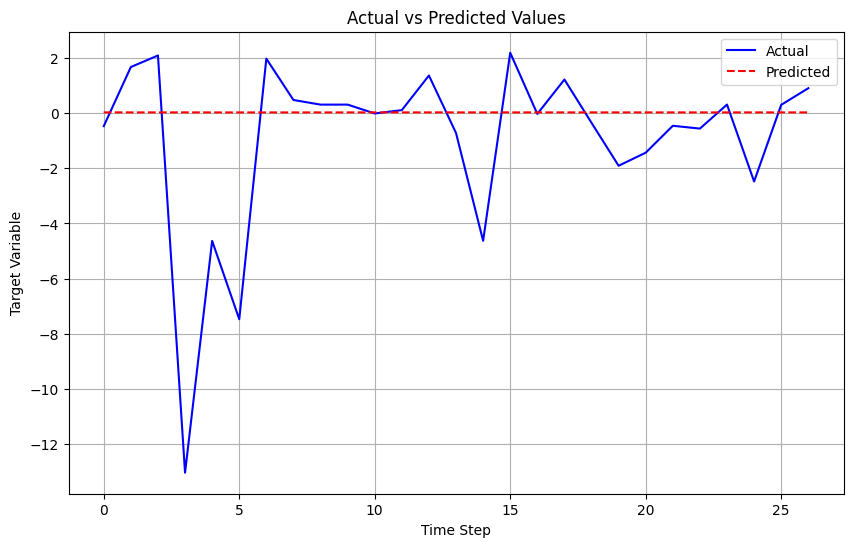

In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- Assume y_train_scaled, y_test_scaled, and scaler_y are already defined ---

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    for i in range(len(data) - n_past - n_future + 1):
        X.append(data[i:i+n_past])
        y.append(data[i+n_past:i+n_past+n_future])
    return np.array(X), np.array(y)

# Best hyperparameters found (manually set here)
best_params = {
    'n_past': 3,
    'n_neurons': 47,
    'n_layers': 3,
    'activation': 'sigmoid',
    'dropout_rate': 0.43395311782482304,
    'batch_size': 1,
    'optimizer': 'rmsprop',
    'epochs': 63
}

n_past = best_params["n_past"]
n_neurons = best_params["n_neurons"]
n_layers = best_params["n_layers"]
activation = best_params["activation"]
dropout_rate = best_params["dropout_rate"]
batch_size = best_params["batch_size"]
optimizer = best_params["optimizer"]
epochs = best_params["epochs"]

# Create sequences
X_train, y_train = create_sequences(y_train_scaled, n_past, 1)
X_test, y_test = create_sequences(y_test_scaled, n_past, 1)

# Reshape inputs for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

# Build the model
model = Sequential()

# First LSTM layer
model.add(LSTM(n_neurons, activation=activation, return_sequences=(n_layers > 1), input_shape=(n_past, 1)))
model.add(Dropout(dropout_rate))

# Additional LSTM layers
for i in range(n_layers - 1):
    return_seq = i < n_layers - 2  # Only return sequences for intermediate layers
    model.add(LSTM(n_neurons, activation=activation, return_sequences=return_seq))
    model.add(Dropout(dropout_rate))

# Output layer
model.add(Dense(1))

# Compile model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

# Predict
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate metrics
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, y_pred)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R-squared: {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Target Variable')
plt.legend()
plt.grid(True)
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

--- Training Metrics ---
Train RMSE: 1.6467
Train MSE: 2.7118
Train MAE: 1.0311
Train MAPE: 111.20%
Train R-squared: -0.0026


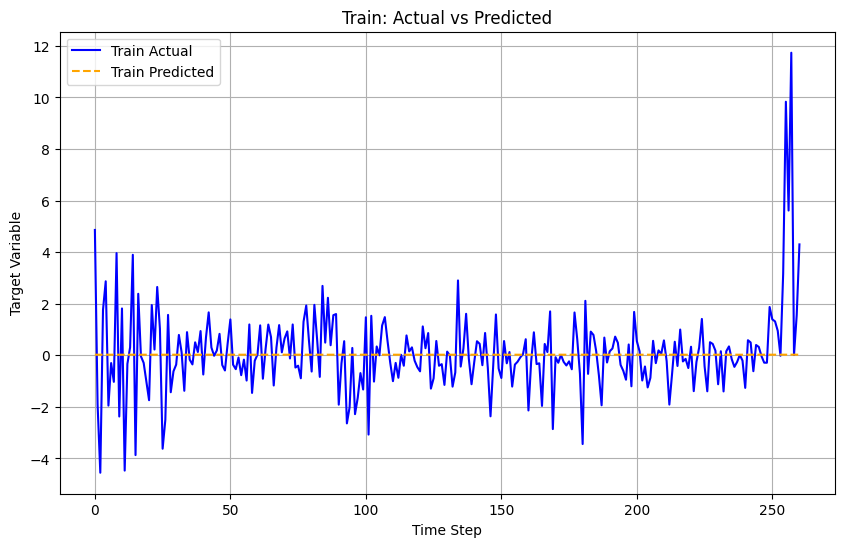

In [10]:
# --- Train Predictions ---
y_train_pred_scaled = model.predict(X_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_actual = scaler_y.inverse_transform(y_train)

# Optional: Calculate metrics on training data
train_mse = mean_squared_error(y_train_actual, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
train_mape = np.mean(np.abs((y_train_actual - y_train_pred) / y_train_actual)) * 100
train_r2 = r2_score(y_train_actual, y_train_pred)

# Print training metrics
print("\n--- Training Metrics ---")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Train R-squared: {train_r2:.4f}")

# Plot train actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_train_actual, label='Train Actual', color='blue')
plt.plot(y_train_pred, label='Train Predicted', color='orange', linestyle='--')
plt.title('Train: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Target Variable')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
df

,Residuals_SVR
Date,
2000-10-31,0.008275
2000-11-30,-0.305147
2000-12-31,3.588124
2001-01-31,4.862272
2001-02-28,-1.912424
...,...
2024-11-30,-0.563288
2024-12-31,0.307545
2025-01-31,-2.480250


In [14]:
# Step 1: Combine the full scaled target data
y_full_scaled = np.concatenate((y_train_scaled, y_test_scaled), axis=0)

# Step 2: Create full sequences
X_full, y_full_seq = create_sequences(y_full_scaled, n_past, 1)
X_full = X_full.reshape((X_full.shape[0], X_full.shape[1], 1))
y_full_seq = y_full_seq.reshape((y_full_seq.shape[0], y_full_seq.shape[1]))

# Step 3: Predict using the trained model
y_full_pred_scaled = model.predict(X_full)

# Step 4: Inverse transform both prediction and actual values
y_full_pred = scaler_y.inverse_transform(y_full_pred_scaled)
y_full_actual = scaler_y.inverse_transform(y_full_seq)

# Step 5: Prepare the datetime index for predictions
# Assume `full_datetime_index` is a pandas DateTimeIndex with length equal to len(y_full_original)
# Step 5: Prepare the datetime index for predictions
prediction_index = df.index[n_past:]  # Ensure this is a 1D DateTimeIndex

# Step 6: Store in DataFrame
results_df = pd.DataFrame({
    'DateTime': prediction_index,
    'Actual': y_full_actual.ravel(),
    'Predicted': y_full_pred.ravel()
})
results_df.set_index('DateTime', inplace=True)

# Step 7: Export to Excel
results_df.to_excel('full_predictions.xlsx')




10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [15]:
results_df

,Actual,Predicted
DateTime,,
2001-01-31,4.862272,0.024095
2001-02-28,-1.912424,0.024424
2001-03-31,-4.553144,0.024187
2001-04-30,1.766259,0.023636
2001-05-31,2.871336,0.023558
...,...,...
2024-11-30,-0.563288,0.023539
2024-12-31,0.307545,0.023620
2025-01-31,-2.480250,0.023753


In [17]:
df_backup

,Inflation,SVR_Prediction,Residuals_SVR
Date,,,
2000-10-31,7.794494,7.786219,0.008275
2000-11-30,7.559566,7.864713,-0.305147
2000-12-31,10.836729,7.248605,3.588124
2001-01-31,16.170425,11.308153,4.862272
2001-02-28,16.618124,18.530548,-1.912424
...,...,...,...
2024-11-30,-2.068252,-1.504964,-0.563288
2024-12-31,-1.742696,-2.050241,0.307545
2025-01-31,-4.035874,-1.555624,-2.480250


In [18]:
merged_df = pd.merge(df_backup, results_df, left_index=True, right_index=True, how='inner')
merged_df

,Inflation,SVR_Prediction,Residuals_SVR,Actual,Predicted
2001-01-31,16.170425,11.308153,4.862272,4.862272,0.024095
2001-02-28,16.618124,18.530548,-1.912424,-1.912424,0.024424
2001-03-31,13.213922,17.767066,-4.553144,-4.553144,0.024187
2001-04-30,13.874019,12.107760,1.766259,1.766259,0.023636
2001-05-31,16.256885,13.385549,2.871336,2.871336,0.023558
...,...,...,...,...,...
2024-11-30,-2.068252,-1.504964,-0.563288,-0.563288,0.023539
2024-12-31,-1.742696,-2.050241,0.307545,0.307545,0.023620
2025-01-31,-4.035874,-1.555624,-2.480250,-2.480250,0.023753
2025-02-28,-4.187438,-4.485024,0.297586,0.297586,0.023569


In [19]:
merged_df['SVR_LSTM'] = merged_df['SVR_Prediction'] + merged_df['Predicted']
merged_df

,Inflation,SVR_Prediction,Residuals_SVR,Actual,Predicted,SVR_LSTM
2001-01-31,16.170425,11.308153,4.862272,4.862272,0.024095,11.332248
2001-02-28,16.618124,18.530548,-1.912424,-1.912424,0.024424,18.554971
2001-03-31,13.213922,17.767066,-4.553144,-4.553144,0.024187,17.791253
2001-04-30,13.874019,12.107760,1.766259,1.766259,0.023636,12.131396
2001-05-31,16.256885,13.385549,2.871336,2.871336,0.023558,13.409107
...,...,...,...,...,...,...
2024-11-30,-2.068252,-1.504964,-0.563288,-0.563288,0.023539,-1.481425
2024-12-31,-1.742696,-2.050241,0.307545,0.307545,0.023620,-2.026622
2025-01-31,-4.035874,-1.555624,-2.480250,-2.480250,0.023753,-1.531871
2025-02-28,-4.187438,-4.485024,0.297586,0.297586,0.023569,-4.461455


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Step 1: Split into train (90%) and test (10%) by index
split_index = int(len(merged_df) * 0.9)

train_df = merged_df.iloc[:split_index]
test_df = merged_df.iloc[split_index:]

# Step 2: Extract true and predicted values for test set
y_test_actual = test_df['Inflation'].values
y_test_pred = test_df['SVR_LSTM'].values

# Step 3: Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_test_pred)
mape = np.mean(np.abs((y_test_actual - y_test_pred) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, y_test_pred)

# Step 4: Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test R-squared: {r2:.4f}")


Test RMSE: 3.2365
Test MSE: 10.4750
Test MAE: 1.8635
Test MAPE: 63.60%
Test R-squared: 0.9792


## SVM_LSTM hybrid

Test RMSE: 3.2365
Test MSE: 10.4750
Test MAE: 1.8635
Test MAPE: 63.60%
Test R-squared: 0.9792


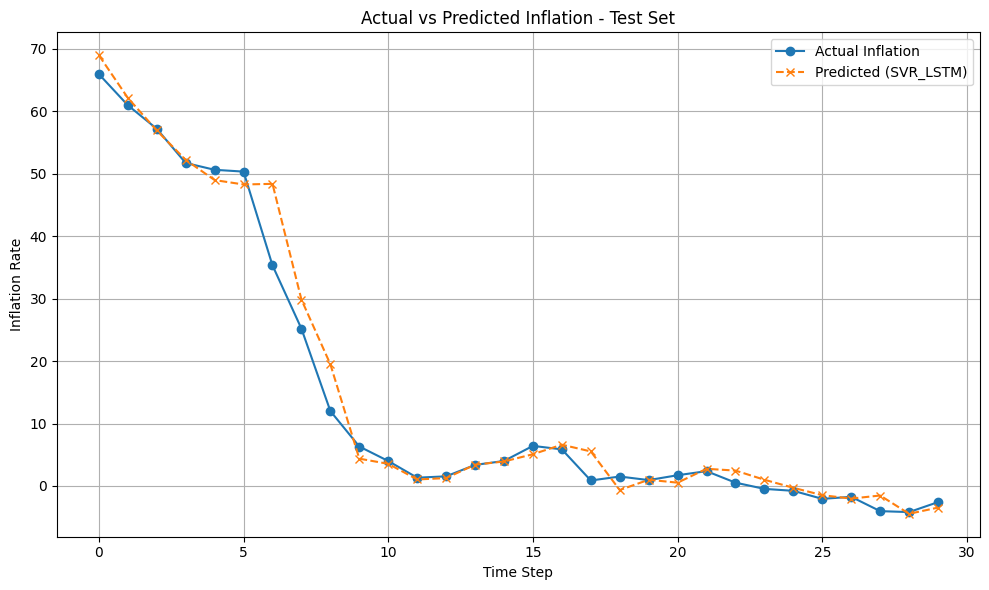

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Split into train (90%) and test (10%) by index
split_index = int(len(merged_df) * 0.9)
train_df = merged_df.iloc[:split_index]
test_df = merged_df.iloc[split_index:]

# Step 2: Extract true and predicted values for test set
y_test_actual = test_df['Inflation'].values
y_test_pred = test_df['SVR_LSTM'].values

# Step 3: Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_test_pred)
mape = np.mean(np.abs((y_test_actual - y_test_pred) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, y_test_pred)

# Step 4: Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test R-squared: {r2:.4f}")

# Step 5: Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Inflation', marker='o')
plt.plot(y_test_pred, label='Predicted (SVR_LSTM)', marker='x', linestyle='--')
plt.title('Actual vs Predicted Inflation - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Inflation Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
RMSE: 3.3448
MSE: 11.1879
MAE: 1.9035
MAPE: 97.66%
R-squared: -0.0818


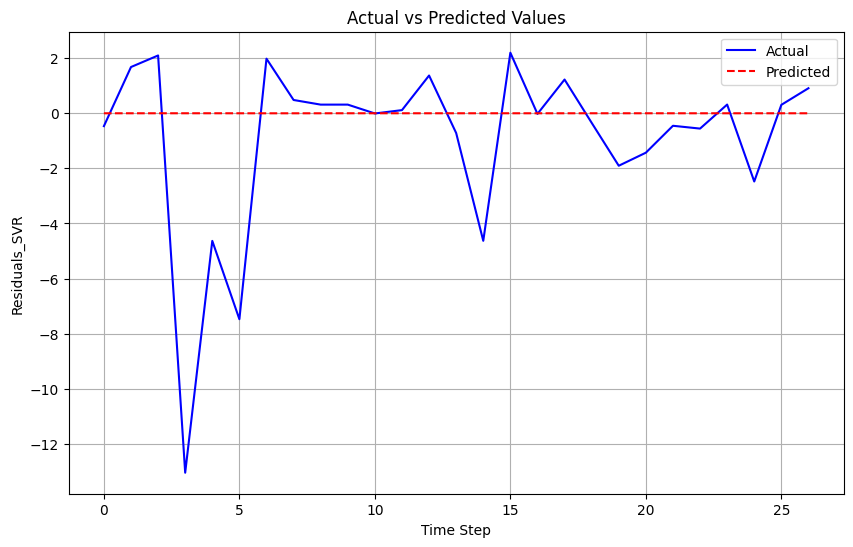

In [21]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Load your dataset ===
# Ensure df exists and has a column named 'Residuals_SVR'
# Example: df = pd.read_csv("your_data.csv")

# Train-test split
train_size = int(len(df) * 0.9)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Use the target variable
y_train = train_data['Residuals_SVR'].values.reshape(-1, 1)
y_test = test_data['Residuals_SVR'].values.reshape(-1, 1)

# Normalize the target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Function to create sequences
def create_sequences(data, n_past, n_future):
    X, y = [], []
    for i in range(len(data) - n_past - n_future + 1):
        X.append(data[i:i+n_past, 0])
        y.append(data[i+n_past+n_future-1, 0])
    return np.array(X), np.array(y).reshape(-1, 1)

# === Best hyperparameters ===
best_params = {
    'n_past': 3,
    'n_neurons': 47,
    'n_layers': 3,
    'activation': 'sigmoid',
    'dropout_rate': 0.43395311782482304,
    'batch_size': 1,
    'optimizer': 'rmsprop',
    'epochs': 63
}

n_past = best_params["n_past"]
n_neurons = best_params["n_neurons"]
n_layers = best_params["n_layers"]
activation = best_params["activation"]
dropout_rate = best_params["dropout_rate"]
batch_size = best_params["batch_size"]
optimizer = best_params["optimizer"]
epochs = best_params["epochs"]

# Create sequences
X_train, y_train_seq = create_sequences(y_train_scaled, n_past, 1)
X_test, y_test_seq = create_sequences(y_test_scaled, n_past, 1)

# Reshape inputs for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(n_neurons, activation=activation, return_sequences=(n_layers > 1), input_shape=(n_past, 1)))
model.add(Dropout(dropout_rate))

# Additional layers
for i in range(n_layers - 1):
    return_seq = i < n_layers - 2
    model.add(LSTM(n_neurons, activation=activation, return_sequences=return_seq))
    model.add(Dropout(dropout_rate))

# Output layer
model.add(Dense(1))

# Compile model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Fit model
model.fit(X_train, y_train_seq, epochs=epochs, batch_size=batch_size, verbose=0)

# Predict
y_pred_scaled = model.predict(X_test)

# Inverse transform to get actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

# === Evaluation ===
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, y_pred)

# Print metrics
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R-squared: {r2:.4f}")

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Residuals_SVR')
plt.legend()
plt.grid(True)
plt.show()
